<center>
    <h1> ANN </h1>
</center>

In [121]:
import pandas as pd
import numpy as np
import pathlib
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import librosa  
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv("../../data/main_df.csv")
df.head()

,files,label
0,../../data/audio-files/03-01-01-01-01-01-01.wav,achievement
1,../../data/audio-files/03-01-01-01-01-01-02.wav,pain
2,../../data/audio-files/03-01-01-01-01-01-03.wav,surprise
3,../../data/audio-files/03-01-01-01-01-01-04.wav,anger
4,../../data/audio-files/03-01-01-01-01-01-05.wav,anger


In [12]:
df['label'].value_counts()

neutral        688
surprise       672
anger          672
fear           672
sad            592
happy          592
disgust        592
achievement     80
pain            80
pleasure        80
Name: label, dtype: int64

In [13]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example
path = np.array(df.files)[0]
data, sample_rate = librosa.load(path)

### Simple Audio

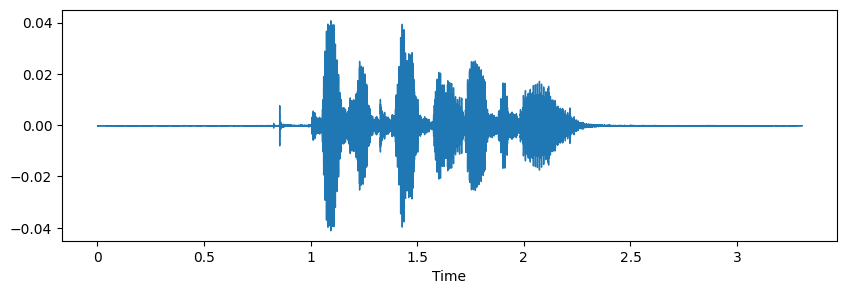

In [16]:
plt.figure(figsize=(10,3))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

### Noise Injection

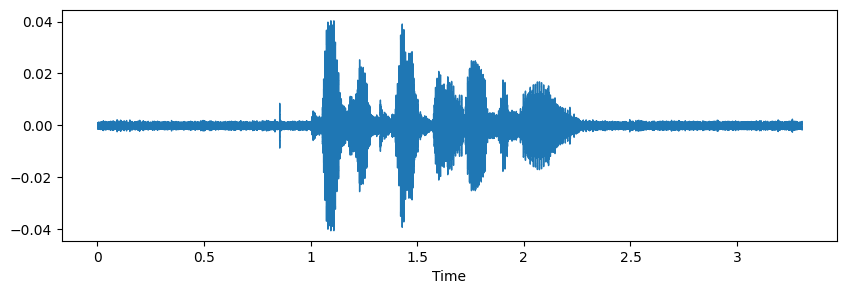

In [17]:
x = noise(data)

plt.figure(figsize=(10,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Streching

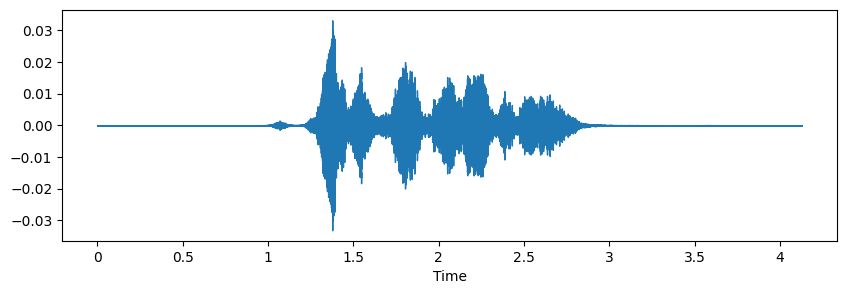

In [19]:
x = stretch(data)

plt.figure(figsize=(10,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Shifting

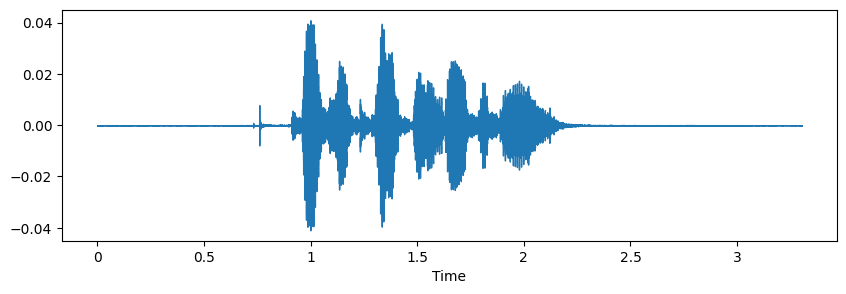

In [20]:
x = shift(data)

plt.figure(figsize=(10,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Pitch

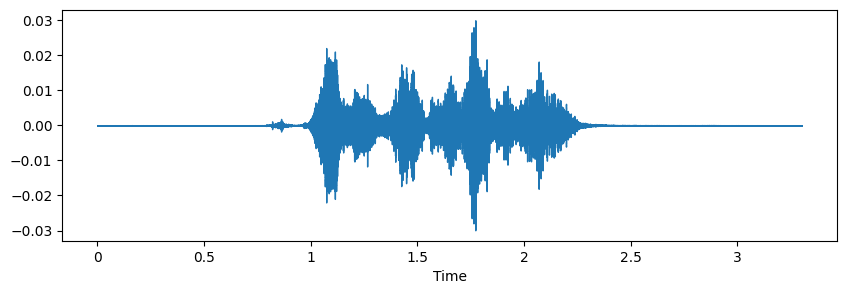

In [21]:
x = pitch(data, sample_rate)

plt.figure(figsize=(10,3))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction

In [22]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=44100, n_mfcc=13).T, axis=0)
    return mfcc

In [24]:
extract_mfcc(df['files'][0])

array([-712.8293   ,   56.89878  ,   -6.596213 ,    6.852001 ,
         -8.759109 ,  -10.841458 ,   -7.859481 ,   -1.5708789,
         -2.048923 ,    2.5723624,   -9.394183 ,   -4.3236246,
         -3.6195884], dtype=float32)

In [25]:
X_mfcc = df['files'].apply(lambda x: extract_mfcc(x))
X_mfcc

0       [-712.8293, 56.89878, -6.596213, 6.852001, -8....
1       [-670.3204, 50.507904, -20.511887, 1.2814244, ...
2       [-632.6799, 56.438377, -12.927864, 2.685068, -...
3       [-709.80225, 38.904476, -17.39579, 0.05100309,...
4       [-719.4747, 72.72103, 1.1598217, 10.59199, -1....
                              ...                        
4715    [-366.04224, 25.840944, -4.2508063, 11.36861, ...
4716    [-369.03928, 17.082626, -8.44738, 18.633675, -...
4717    [-428.65427, 68.387924, -0.22776844, 19.331093...
4718    [-397.1585, 36.290638, -17.414787, -4.65037, -...
4719    [-425.5859, 70.597206, 29.557608, 18.487309, -...
Name: files, Length: 4720, dtype: object

In [26]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(4720, 13)

In [86]:
X = X[:, :, 0]

In [27]:
X = np.expand_dims(X, -1)
X.shape

(4720, 13, 1)

In [28]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [29]:
y = y.toarray()

In [89]:
y.shape

(4720, 10)

In [113]:
X.shape

(4720, 13)

In [32]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

In [116]:
model_ann = keras.Sequential([
    keras.layers.Dense(64, input_shape=(13,), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

In [117]:
model_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [118]:
model_ann.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 64)                896       
                                                                 
 dense_71 (Dense)            (None, 32)                2080      
                                                                 
 dense_72 (Dense)            (None, 16)                528       
                                                                 
 dense_73 (Dense)            (None, 10)                170       
                                                                 
Total params: 3,674
Trainable params: 3,674
Non-trainable params: 0
_________________________________________________________________


In [120]:
history = model_ann.fit(X, y, validation_split=0.2, epochs=1000, batch_size=64)

Epoch 1/1000
59/59 [==============================] - 0s 6ms/step - loss: 2.0522 - accuracy: 0.1780 - val_loss: 2.0409 - val_accuracy: 0.1430
Epoch 2/1000
59/59 [==============================] - 0s 4ms/step - loss: 2.0525 - accuracy: 0.1790 - val_loss: 2.0527 - val_accuracy: 0.1419
Epoch 3/1000
59/59 [==============================] - 0s 4ms/step - loss: 2.0534 - accuracy: 0.1777 - val_loss: 2.0772 - val_accuracy: 0.1430
Epoch 4/1000
59/59 [==============================] - 0s 4ms/step - loss: 2.0566 - accuracy: 0.1766 - val_loss: 2.0745 - val_accuracy: 0.1441
Epoch 5/1000
59/59 [==============================] - 0s 4ms/step - loss: 2.0650 - accuracy: 0.1753 - val_loss: 2.0401 - val_accuracy: 0.1451
Epoch 6/1000
59/59 [==============================] - 0s 4ms/step - loss: 2.0701 - accuracy: 0.1748 - val_loss: 2.0334 - val_accuracy: 0.1462
Epoch 7/1000
59/59 [==============================] - 0s 4ms/step - loss: 2.0625 - accuracy: 0.1751 - val_loss: 2.0399 - val_accuracy: 0.1441
Epoch 

In [114]:
from keras.optimizers import SGD
opt = SGD(lr=0.01)
model_ann.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

In [115]:
history = model_ann.fit(X, y, validation_split=0.2, epochs=100, batch_size=64)

Epoch 1/100
59/59 [==============================] - 1s 6ms/step - loss: 2.8433 - accuracy: 0.1488 - val_loss: 1.9511 - val_accuracy: 0.1335
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 2.8434 - accuracy: 0.1488 - val_loss: 1.9512 - val_accuracy: 0.1335
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 2.8433 - accuracy: 0.1488 - val_loss: 1.9513 - val_accuracy: 0.1335
Epoch 4/100
59/59 [==============================] - 0s 3ms/step - loss: 2.8433 - accuracy: 0.1488 - val_loss: 1.9513 - val_accuracy: 0.1335
Epoch 5/100
59/59 [==============================] - 0s 4ms/step - loss: 2.8433 - accuracy: 0.1488 - val_loss: 1.9513 - val_accuracy: 0.1335
Epoch 6/100
59/59 [==============================] - 0s 4ms/step - loss: 2.8433 - accuracy: 0.1488 - val_loss: 1.9513 - val_accuracy: 0.1335
Epoch 7/100
59/59 [==============================] - 0s 3ms/step - loss: 2.8433 - accuracy: 0.1488 - val_loss: 1.9513 - val_accuracy: 0.1335
Epoch 8/100
5

In [123]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

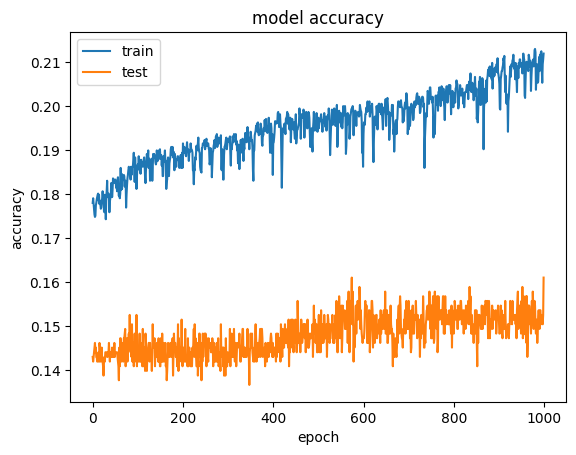

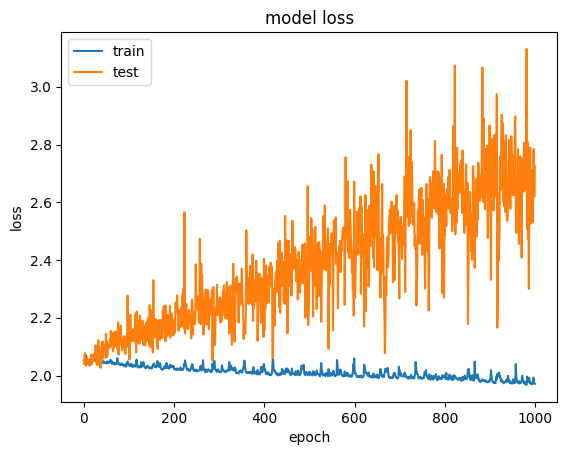

In [130]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()